In [1]:
import numpy as np
import torch
import torch.nn as nn
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.colors as pc
import time
import pandas as pd


In [2]:
class Network(nn.Module):

    def __init__(self, input, width, depth, output):
        super().__init__()

        # activation function
        activation = nn.Tanh

        # input layer
        self.input = nn.Sequential(*[nn.Linear(input, depth), activation()])

        # hidden layers
        self.hidden = nn.Sequential(
            *[
                nn.Sequential(*[nn.Linear(depth, depth), activation()])
                for _ in range(width - 2)
            ]
        )

        # output layer
        self.output = nn.Linear(depth, output)

        self.constants()

    def constants(self):
        self.L = 0.1  # m

        self.cp = 0.7  # J/gK
        self.p = 8000  # kg/m^3
        self.k = 15  # W/mK

        self.a = self.k / (self.p * self.cp)  # m^2/s

        self.t_ref_t = 1473  # K
        self.t_ref_b = 1273  # K

        self.ht = 200
        self.hb = 100

        self.Bi_t = self.ht * self.L / self.k
        self.Bi_b = self.hb * self.L / self.k

        self.lossTotal = None
        self.epochData = {}

        pio.templates["dark"] = go.layout.Template(
            {
                "layout": {
                    "font": {"color":"white","family":"Artifakt Element"},
                    "plot_bgcolor": "rgba(0,0,0,0)",
                    "paper_bgcolor": "rgba(0,0,0,0)",
                    "xaxis": {"color": "white"},
                    "yaxis": {"color": "white"},
                    "scene_zaxis": {"color": "white"},
                    "scene_camera": {"eye": {"x": 1.25, "y": 1.25, "z": 1.25}},
                }
            }
        )
        
        pio.templates["light"] = go.layout.Template(
            {
                "layout": {
                    "font": {"size": 14, "family":"cmu sans serif"},
                    "scene": {
                        "yaxis": {
                            "gridwidth": 4,
                            "gridcolor": "rgb(242,242,242)",
                        },
                        "xaxis": {
                            "gridwidth": 4,
                            "gridcolor": "rgb(242,242,242)",
                        },
                        "zaxis": {
                            "gridwidth": 4,
                            "gridcolor": "rgb(242,242,242)",
                        },
                    },
                    "xaxis": {
                        "automargin": True,
                        "gridcolor": "rgb(242,242,242)",
                        "linecolor": "rgb(36,36,36)",
                        "showgrid": True,
                        "showline": True,
                        "ticks": "outside",
                        "title": {"standoff": 15},
                        "zeroline": False,
                    },
                    "yaxis": {
                        "automargin": True,
                        "gridcolor": "rgb(242,242,242)",
                        "linecolor": "rgb(36,36,36)",
                        "showgrid": True,
                        "showline": True,
                        "ticks": "outside",
                        "title": {"standoff": 15},
                        "zeroline": False,
                    },
                }
            }
        )
        self.setPresentationMode(False)

    def forward(self, x, t):
        inp = torch.cat((x, t), dim=1)
        inp = self.input(inp)
        inp = self.hidden(inp)
        inp = self.output(inp)
        return inp

    def init_boundaries(self, N):

        # x and t boundary points for training x boundaries, x = -1,1, varying t values
        minusx_boundary = (
            torch.tensor(-1.0).repeat(N).view(-1, 1).requires_grad_(True).to(device)
        )
        x_boundary = (
            torch.tensor(1.0).repeat(N).view(-1, 1).requires_grad_(True).to(device)
        )
        t_boundary = 10 * torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

        # 0 time boundary for training
        x_IC = (
            (-2 * torch.rand(N) + 1).view(-1, 1).requires_grad_(True).to(device)
        )  # X = -1,1 random values
        t_IC = (
            torch.tensor(0.0).repeat(N).view(-1, 1).requires_grad_(True).to(device)
        )  # T = 0

        self.BCpoints = [minusx_boundary, x_boundary, t_boundary]
        self.ICs = [x_IC, t_IC]

    def sample(self, N):

        # sample points for training
        x = (-2 * torch.rand(N) + 1).view(-1, 1).requires_grad_(True).to(device)
        t = (10 * torch.rand(N)).view(-1, 1).requires_grad_(True).to(device)

        return x, t

    def derivative(self, f, x):
        return torch.autograd.grad(
            f, x, grad_outputs=torch.ones_like(f).to(device), create_graph=True
        )[0]

    def losses(self, N):

        self.init_boundaries(N)
        x_points, t_points = self.sample(N)

        # losses for x and t boundaries
        T = self.forward(self.BCpoints[0], self.BCpoints[2])
        T_x = self.derivative(T, self.BCpoints[0])

        minusx_loss = (T_x - self.Bi_b * T) ** 2

        T1 = self.forward(self.BCpoints[1], self.BCpoints[2])
        T_x1 = self.derivative(T1, self.BCpoints[1])

        x_loss = (T_x1 + self.Bi_t * (T1 - 1)) ** 2

        # loss for initial condition

        T_IC = self.forward(self.ICs[0], self.ICs[1])
        t0_loss = (T_IC - 1) ** 2

        # loss for physics sample
        T_phy = self.forward(x_points, t_points)
        T_x_phy = self.derivative(T_phy, x_points)
        T_xx_phy = self.derivative(T_x_phy, x_points)
        T_t_phy = self.derivative(T_phy, t_points)

        phys_loss = (T_t_phy - 4 * T_xx_phy) ** 2

        loss = (
            torch.mean(minusx_loss)
            + torch.mean(x_loss)
            + 10 * torch.mean(t0_loss)
            + torch.mean(phys_loss)
        )
        return None if torch.isnan(loss) else loss

    def train(self, epochs_max, N, optimiser="LBFGS", lr=1):

        def closure():
            optimizer.zero_grad()
            loss = self.losses(N)
            loss.backward()
            return loss

        self.lossTotal = self.lossTotal or [1]
        loss_val = self.lossTotal[-1]
        epoch = len(self.lossTotal) - 1
        epoch_times = []
        window_size = 10

        if optimiser == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimiser == "LBFGS":
            optimizer = torch.optim.LBFGS(
                self.parameters(),
                max_iter=1000,
                history_size=1000,
                tolerance_grad=1.0 * np.finfo(float).eps,
                tolerance_change=1.0 * np.finfo(float).eps,
                line_search_fn="strong_wolfe",
            )
        else:
            raise ValueError("Invalid optimiser")

        start = time.time()

        while epoch < epochs_max and loss_val > 1e-6:
            epoch += 1
            if optimiser == "Adam":
                optimizer.zero_grad()
                loss = self.losses(N)
                loss.backward()
                optimizer.step()
            else:
                loss = optimizer.step(closure)

            loss_val = loss.item()
            self.lossTotal.append(loss_val)

            # compute epoch time
            epoch_time = time.time() - start
            epoch_times.append(epoch_time)
            start = time.time()  # Reset the start time for the next epoch

            # Compute the moving average of epoch times
            if len(epoch_times) > window_size:
                epoch_times = epoch_times[-window_size:]
            avg_epoch_time = sum(epoch_times) / len(epoch_times)

            # Calculate the remaining time
            time_remaining = (epochs_max - epoch) * avg_epoch_time

            # print loss and parameter values
            print(
                f'Epoch: {epoch}  Loss: {loss_val:.8f} Time/Epoch: {avg_epoch_time:.4f}s ETA: {time.strftime("%H Hours %M Minutes and %S Seconds", time.gmtime(time_remaining))}',
                end="\r",
            )
            if epoch in (
                [1, 50, 100, 200, 500, 1000, 2000, 5000]
                + list(range(5000, 100001, 10000))
            ):
                self.storeData(epoch)

        self.storeData(epoch)

    def storeData(self, epoch):
        X = torch.linspace(-1, 1, 100).to(device)
        T = torch.linspace(0, 10, 100).to(device)
        X_grid, T_grid = torch.meshgrid(X, T)

        Temp = (
            (self.forward(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1)))
            .reshape(100, 100)
            .cpu()
            .detach()
            .numpy()
        )  # Predicted temperature
        self.epochData[epoch] = Temp

    def setPresentationMode(self, state):
        if state:
            self.theme = "light"
            pio.renderers.default = "svg"
        else:
            self.theme = "dark"
            pio.renderers.default = "plotly_mimetype+notebook"        

    def plotEpochs(self):
        # Create figure
        fig = go.Figure()
        
        fig.update_layout(
            template=self.theme,
            title=dict(text="<b>Temperature Distribution</b>", font=dict(size=30)),
            scene=dict(
                xaxis_title="Time",
                yaxis_title="X",
                zaxis_title="Temperature",
            ),
            scene_camera=dict(eye=dict(x=2/1.2, y=-1.5/1.2, z=1.5/1.2)),
            width=800,
            height=800,
        )
        
        X = np.linspace(-1, 1, 100)
        T = np.linspace(0, 10, 100)
        
        if self.theme == "dark":
            # Add traces, one for each slider step
            for trace in self.epochData.keys():
                fig.add_trace(
                    go.Surface(
                        visible=False,
                        y=X,
                        x=T,
                        z=self.epochData[trace],
                        colorscale="Agsunset",
                    )
                )

            # Make first trace visible
            fig.data[-1].visible = True

            # Create and add slider
            steps = []
            for i, epoch in enumerate(self.epochData.keys()):
                step = dict(
                    method="update",
                    args=[
                        {"visible": [False] * len(fig.data)},
                    ],
                    label=str(epoch),
                )
                step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
                steps.append(step)

            sliders = [
                dict(
                    active=len(self.epochData) - 1,
                    currentvalue={"prefix": "Epoch: "},
                    pad={"t": 5},
                    steps=steps,
                )
            ]
            fig.update_layout(sliders=sliders)
        else:
            last_epoch = list(self.epochData.keys())[-1]
            fig.add_trace(go.Surface(y=X, x=T, z=self.epochData[last_epoch], colorscale="Agsunset"))

        fig.show()

    def plotIC(self):
        fig = go.Figure()
        
        fig.update_layout(
            template=self.theme,
            title=dict(text="<b>Initial Condition</b>", font=dict(size=30)),
            xaxis_title="<b>X</b>",
            yaxis_title="<b>Temperature</b>",
            legend_title="<b>Epochs</b>",
            height=800,
            width = 1600,
        )
        
        if self.theme != "dark":
            last_epoch = list(self.epochData.keys())[-1]
            fig.add_trace(go.Scatter(x=np.linspace(-1, 1, 100), y=self.epochData[last_epoch][:, 0], line={"color": "black"}))
            fig.show()
            return
        
        ICdata = {}
        for key, matrix in self.epochData.items():
            ICdata[key] = matrix[:, 0]  # Get the first column of each matrix

        del ICdata[1]  # remove the first epoch, as it's erroneous

        lines = len(ICdata)

        colours = pc.sample_colorscale("Agsunset", lines, low=0.0, high=1.0, colortype="rgb")  # Get colours for each epoch

        df = pd.DataFrame(ICdata)
        df.index = np.linspace(-1, 1, 100)

        for i, epoch in enumerate(ICdata.keys()):
            fig.add_trace(
                go.Scatter(
                    visible=True,
                    x=df.index,
                    y=df[epoch],
                    line={"color": colours[i]},
                    name=f"Epoch {epoch}",
                )
            )  # Add traces

        # Create and add slider
        steps = [
            dict(
                method="update",
                args=[
                    {"visible": [True] * lines},
                ],
                label="Default view",
            )
        ]  # Default view
        for i in range(lines - 1):
            steps.append(
                dict(
                    method="update",
                    args=[
                        {"visible": [False] * (i + 1) + [True] * (lines - i - 1)},
                    ],
                    label=f"More than {df.columns[i]} epochs",
                )
            )  # Removes visibility of consecutive epochs with each step

        # Add slider
        sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

        fig.update_layout(sliders=sliders)

        fig.show()

    def plotLoss(self):
        fig = px.scatter(
            x=range(len(self.lossTotal)),
            y=self.lossTotal,
            log_y=True,
            log_x=True,
            color=np.log(self.lossTotal),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs (log)", "y": "Loss (log)"},
            trendline="lowess",
            trendline_options=dict(frac=0.005),
            trendline_color_override="midnightblue",
            template=self.theme,
        )
        fig.update_layout(
            title=dict(text="<b>Loss against Epoch</b>", font=dict(size=30)),
            coloraxis_showscale=False,
            height=800,
            width = 1600,
        )
        fig.update_traces(marker=dict(size=6, opacity=0.8))

        fig.show()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# nn seed
torch.manual_seed(987)

# define nn to train, two inputs for x and t
pinn = Network(2, 6, 128, 1).to(device)

# training things
epochs_max = 10000
lrate = 1e-4
N = 10000


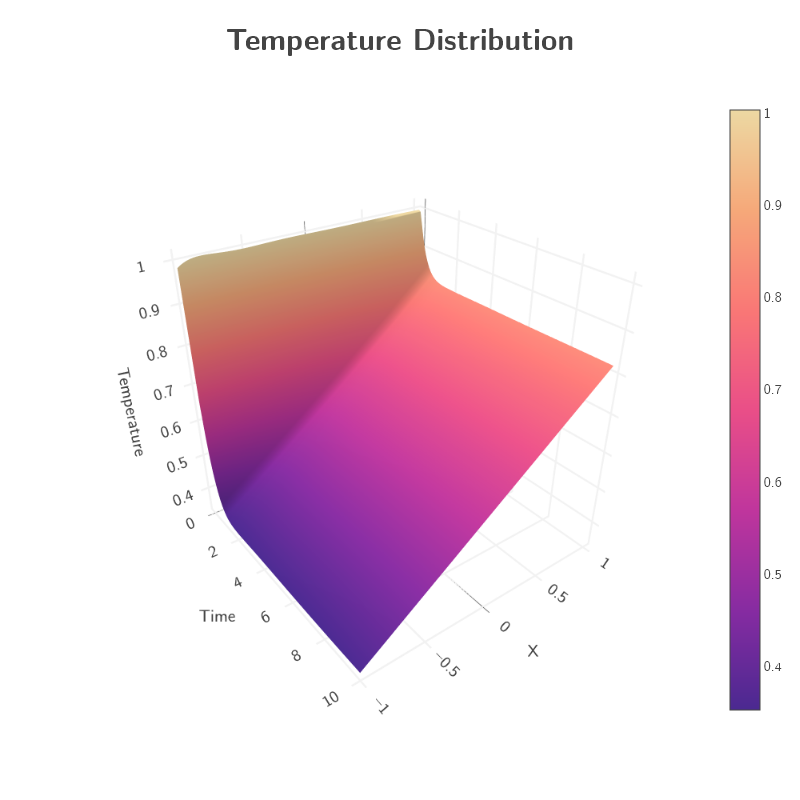

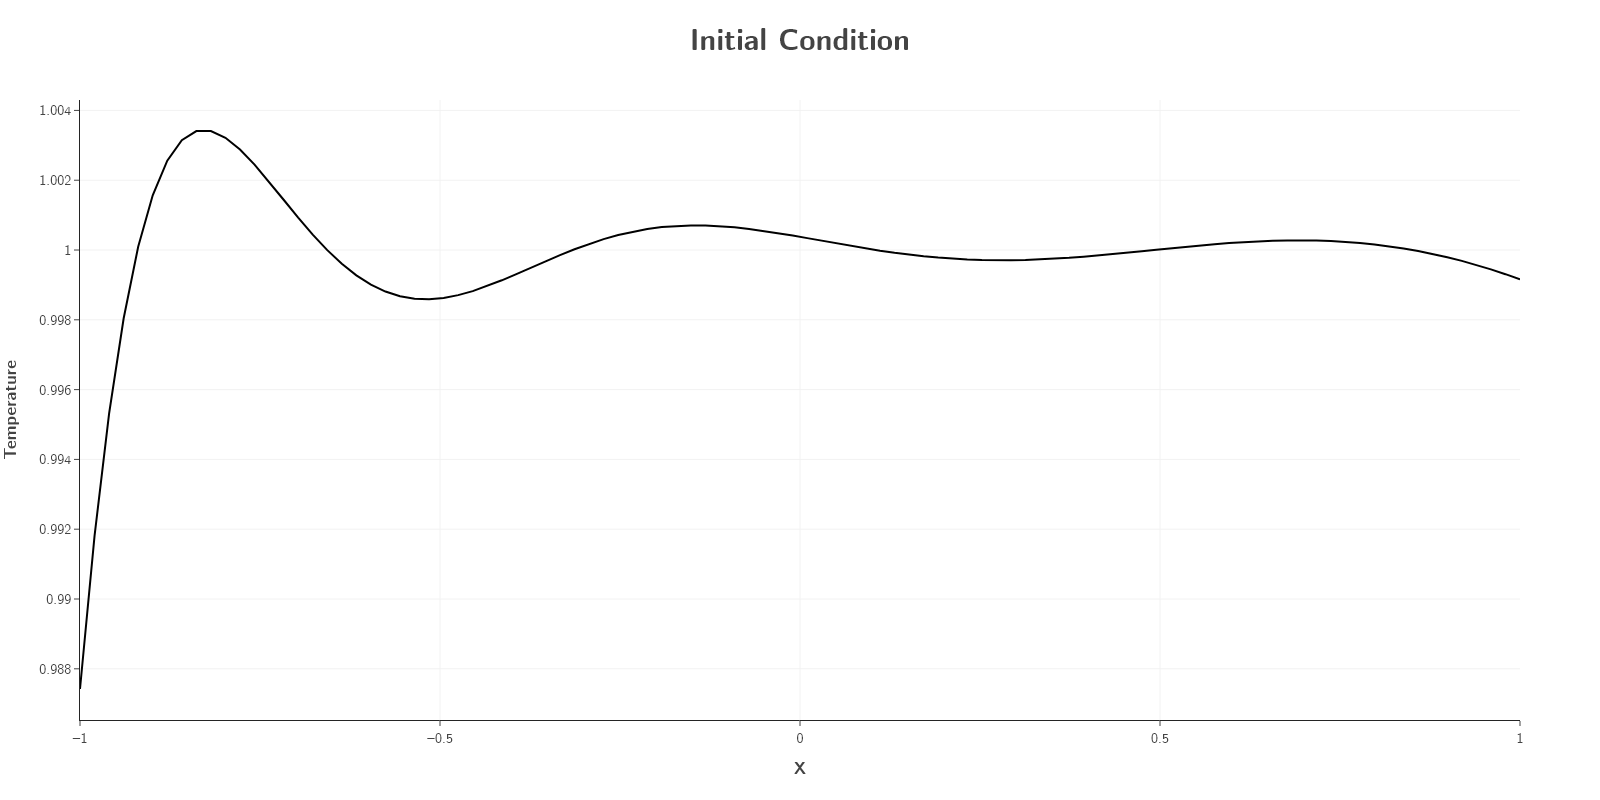

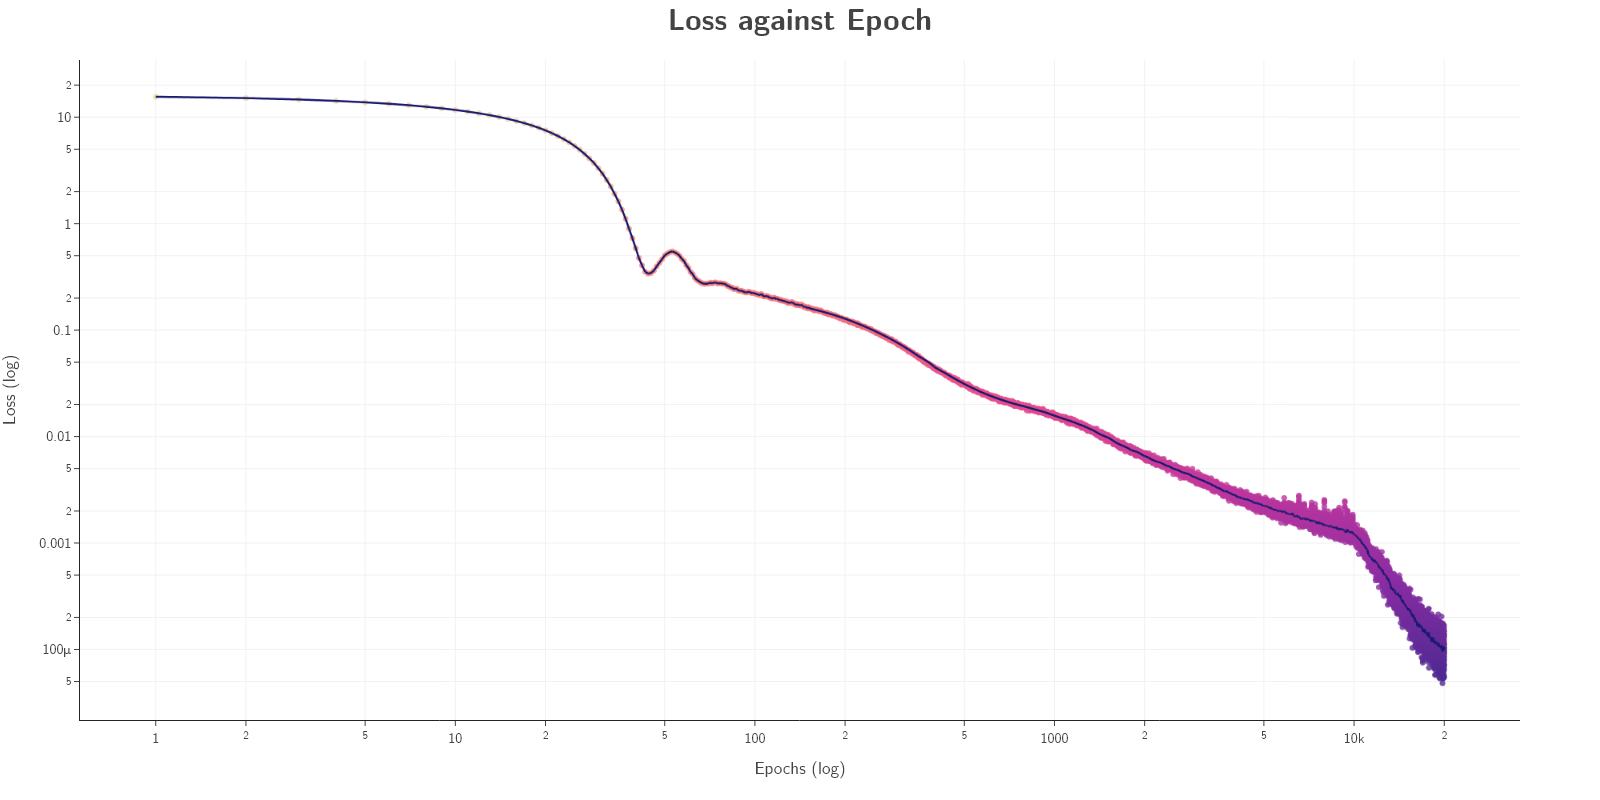

In [6]:
pinn.train(epochs_max, N, 'Adam', lrate)
pinn.train(epochs_max*2, N)
pinn.setPresentationMode(True)
pio.renderers.default = "png"
pinn.plotEpochs()
pinn.plotIC()
pinn.plotLoss()
